# Computer Vision - Project
imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Resizing
from tqdm import tqdm

In [2]:
# IMG_SIZE = (64, 64)
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.resnet(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# base_model.trainable = False

Constants

In [3]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()
SIZE=224


In [4]:
def sort_points(points, center):
    # calculate the angle of each point from the center point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    # sort the points by angle
    sorted_points = points[np.argsort(angles)]
    return sorted_points

In [5]:
def draw_training_curve(history):
	"""
	Draw training curve
	Parameters:
		history - contains loss and accuracy from training
	Returns:
		None
	"""
	plt.figure(1)

	# History for accuracy
	plt.subplot(211)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	# History for loss
	plt.subplot(212)
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	plt.show()

In [6]:
def draw_points(image, points, color=(255, 0, 0), radius=3):
    # create a copy of the image
    img = image.copy()
    # iterate over the points and draw them on the image
    for point in points:
        cv2.circle(img, tuple(map(int, point)), radius, color, -1)
    return img


In [7]:
def get_bb(img, bbs, indx):
    x1 = int(bbs[0,0,indx])
    y1 = int(bbs[1,0,indx])
    x2 = int(bbs[0,1,indx])
    y2 = int(bbs[1,1,indx])
    x3 = int(bbs[0,2,indx])
    y3 = int(bbs[1,2,indx])
    x4 = int(bbs[0,3,indx])
    y4 = int(bbs[1,3,indx])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))
    # points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    
    # create an empty image with the same shape as the input image
    # mask = np.zeros_like(img[:,:,0])
    # create a list of the bounding box points in the correct format
    # bounding_box = np.array([points], dtype=np.int32)
    # fill the area inside the bounding box with white
    # cv2.fillPoly(mask, bounding_box, 255)
    # apply the mask to the image
    ####res = cv2.bitwise_and(img, mask)
    # try1 = np.array(np.where(mask == 255, 255, 0), dtype=np.uint8)
    # print(x)
    # inv_mask = cv2.bitwise_not(mask)
    # res2 = cv2.bitwise_and(img, inv_mask)
    # bb2 = np.int32([[top_left_x, bot_right_y], [bot_right_x, bot_right_y],[bot_right_x,top_left_y], [top_left_x,top_left_y]])
    # print(bb2)
    # mask2 = np.zeros_like(img)
    # # bb2 = np.array(frame, dtype=np.int32)
    # cv2.fillPoly(mask2, bb2, (255, 255, 255))
    # mask = mask[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

    #res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    #flipping
    """"if(x2 < x1):
        res = cv2.flip(res, 1)
    if(y2 < y1):
        res = cv2.flip(res, 0)
    plt.imshow(mask)
    plt.show()
    print(mask.shape)"""
    return res

In [8]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Titillium Web':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Open Sans':
        return 3
    else:
        return 4

In [9]:
def num_to_font(font):
    if font == 0:
        return b'Alex Brush'
    elif font == 1:
        return b'Titillium Web'
    elif font == 2:
        return b'Sansation'
    elif font == 3:
        return b'Open Sans'
    else:
        return b'Ubuntu Mono'

In [10]:
def print_label(set, index):
    line = set[index]
    max = np.argmax(line)
    print(num_to_font(max))

In [11]:
def print_font(max):
     print(num_to_font(max))

In [12]:
def print_photo_from_set(set_x, set_y, index, font):
    plt.imshow(set_x[index], cmap='gray')
    plt.show()
    print_font(font)

In [13]:
def prepare_img(img, bbs, index, size):
    cropped = get_bb(img, bbs, index)
    # _, cropped = cv2.threshold(cropped,127,255,cv2.THRESH_TRIANGLE)
    # print(cropped.shape)
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # cropped = tf.image.rgb_to_grayscale(cropped)
    # # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [14]:
from pathlib import Path
def create_dirs():
    Path('main_directory').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Sansation').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Open Sans').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Ubuntu Mono').mkdir(parents=True, exist_ok=True)
    Path('test_set').mkdir(parents=True, exist_ok=True)
    Path('test_set/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path('test_set/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path('test_set/Sansation').mkdir(parents=True, exist_ok=True)
    Path('test_set/Open Sans').mkdir(parents=True, exist_ok=True)
    Path('test_set/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [15]:
def is_num_or_letter(inp):
    res= ((inp >= ord('a') and inp <= ord('z')) or (inp >= ord('A') and inp <= ord('Z'))) or (inp>=ord('0') and inp<=ord('9'))
    # print(chr(inp)+"="+str(res))
    return res

In [17]:
# OUT_FILE = 'test_set.h5'
# # open the output h5 file:
# out_db = h5py.File(OUT_FILE,'a')
# out_db.require_group('/data')

In [18]:
def add_res_to_db(db,imgname,img,charBB, wordBB,txt ):
  # db['data'].create_dataset(imgname,data=img)
  db['data'][imgname]=img
  db['data'][imgname].attrs['charBB'] = charBB
  db['data'][imgname].attrs['wordBB'] = wordBB
  db['data'][imgname].attrs['txt'] = txt

In [103]:
db = h5py.File(FILE_NAME, 'r')

In [19]:

def get_data_set(db, size: int):
    
    # db_test = h5py.File(OUT_FILE, 'a')
    # test_db = h5py.File('test_db.h5', 'w')
    create_dirs()
    im_names = list(db['data'].keys())
    num = 0
    print(len(db['data'].keys()))
    for i in tqdm(range(0, len(im_names)-1)):
        im = im_names[i]
        img  = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txts = db['data'][im].attrs['txt']
        charBBs = db['data'][im].attrs['charBB']
        wordBBs = db['data'][im].attrs['wordBB']
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            if(j%8!=0):
                cropped = prepare_img(img, wordBBs, j, size)
                path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # print(path)
                tf.keras.utils.save_img(path,cropped)
                # db['data'][im] = 0
                num+=1
                for k in range(0, len(txts[j])):
                    if(is_num_or_letter(txts[j][k])):
                        cropped = prepare_img(img, charBBs, char_indx, size)
                        path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg'
                        # print(path)
                        tf.keras.utils.save_img(path,cropped)
                        num+=1
                        # train_x.append(cropped)
                        # train_y.append(font_to_num(fonts[font_indx]))
                    char_indx+=1
                        # plt.imshow(cropped, cmap='gray')
                        # plt.show()
                        # print(fonts[font_indx])
            else:
                # cropped = prepare_img(img, wordBBs, j, size)
                # db['data'][im][:].resize(224,224,3)
                # db['data'][im][:] = cropped
                # name = 'test_set/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # add_res_to_db(db_test,name,cropped,charBBs[:,:,j:j+len(txts[j])], wordBBs[:,:,j], txts[j])
                # path = 'test_set/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # tf.keras.utils.save_img(path,cropped)
                char_indx+=len(txts[j])
            font_indx += len(txts[j])
    # print(num) 
    # print(len(db_test['data'].keys()))    # return train_x, train_y

In [20]:
from download_h5py_db import download_h5py_db
if not Path("main_directory").exists():
    download_h5py_db()
    get_data_set(db, SIZE)
# train_x, train_y = 

In [21]:
import splitfolders
splitfolders.ratio("main_directory/", # The location of dataset
                   output="main_directory_splitted", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .3), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 5422 files [00:12, 539.03 files/s]

KeyboardInterrupt: 

Copying files: 5474 files [00:30, 539.03 files/s]

In [114]:
from keras.preprocessing.image import ImageDataGenerator
def data_augmentation():
    datagen =  ImageDataGenerator(
        horizontal_flip=True, rotation_range=90, fill_mode='reflect', channel_shift_range=0.8,#
         shear_range=15,vertical_flip=False, brightness_range=(0.2, 0.8),# 
     rescale=1/255, dtype='float32'
     #,validation_split=0.25
     )
    # Path('augmented').mkdir(exist_ok=True)
    it = datagen.flow_from_directory('main_directory_splitted/train/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True, seed=1, keep_aspect_ratio=True)
    datagen_val =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
    val_it = datagen_val.flow_from_directory('main_directory_splitted/val/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True)
    return it, val_it, datagen

In [115]:
it, val_it, datagen = data_augmentation()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'main_directory_splitted/train/'

In [112]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from keras import regularizers
num_classes = 5
input_size= SIZE

baseModel = ResNet50(include_top=False, classes=num_classes,
                         input_shape=(input_size, input_size, 3),
                        weights='imagenet')
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
def scheduler(epoch, lr):
    # if epoch < 5:
    #     return lr
    # else:
    return lr * 0.1 #tf.math.exp(-0.1)

In [29]:
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [30]:
from tensorflow.keras import callbacks
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="drive/MyDrive/top_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [113]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20, verbose=1)
# datagen.fit(X_train)
history = model.fit(it, epochs=1, verbose=1 , shuffle=True, validation_data=val_it
          ,callbacks=callbacks_list
          )

FileNotFoundError: [Errno 2] No such file or directory: 'main_directory_splitted/train/Alex Brush\\koala_28.jpg_0_17129.jpg'

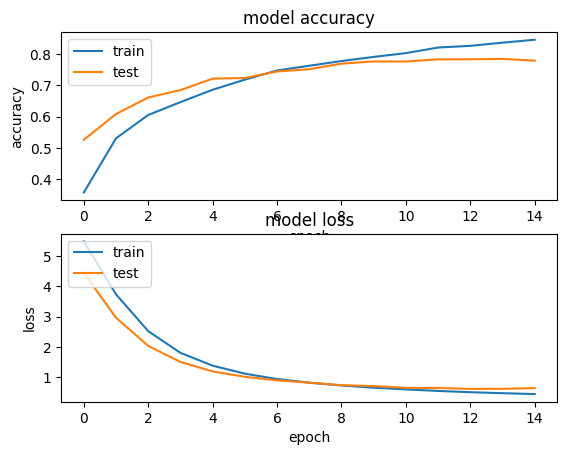

In [ ]:
draw_training_curve(history)

In [32]:
datagen_test =  ImageDataGenerator(rescale=1/255, dtype='float32')
it_test = datagen.flow_from_directory('test_set/', batch_size=18, class_mode='categorical', shuffle=True, seed=1, keep_aspect_ratio=True)

Found 1406 images belonging to 5 classes.


In [33]:
score = model.evaluate(it_test)

79/79 [==============================] - 27s 307ms/step - loss: 1.2148 - accuracy: 0.6650


In [34]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.2147831916809082 / Test accuracy: 0.6650071144104004


632/632 [==============================] - 161s 254ms/step - loss: 0.2479 - accuracy: 0.6977
632/632 [==============================] - 53s 82ms/step - loss: 1.6858 - accuracy: 0.5157
632/632 [==============================] - 150s 236ms/step - loss: 0.8984 - accuracy: 0.6251

In [132]:

def get_predicted(size: int):
    db = h5py.File(FILE_NAME, 'r')
    # db_test = h5py.File(OUT_FILE, 'a')
    # test_db = h5py.File('test_db.h5', 'w')
    create_dirs()
    im_names = list(db['data'].keys())
    num = 0
    print(len(db['data'].keys()))
    results = []
    for i in range(0, len(im_names)-1):
        im = im_names[i]
        img  = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txts = db['data'][im].attrs['txt']
        charBBs = db['data'][im].attrs['charBB']
        # wordBBs = db['data'][im].attrs['wordBB']
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            if(j%8==0):
                chars=[]
                for k in range(0, len(txts[j])):
                    if(is_num_or_letter(txts[j][k])):
                        cropped = prepare_img(img, charBBs, char_indx, size)
                        
                        
                        chars.append(cropped)
                        # print(chars.shape)
                        # labels.append(fonts[j])
                        num+=1
                    char_indx+=1
                
                chars = np.asarray(chars, dtype="float32")
                # print(chars)
                for img_ch in chars:
                    plt.imshow(img_ch)
                    plt.show()
                res = model.predict(chars, verbose=0)
                print(fonts[j])
                print(res)
                max = np.argmax(res, axis=1)
                print(max)
                # if(max!=font_to_num(fonts[j])):
                #     print(str(False))
                #     results.append(False)
                # else:
                #     print(str(True))
                #     results.append(True)
                # print(results[len(results)-1])
            #     print(max)
            #     print(np.bincount(max).argmax())
            # else:
                char_indx+=len(txts[j])
            font_indx += len(txts[j])
    return results

998


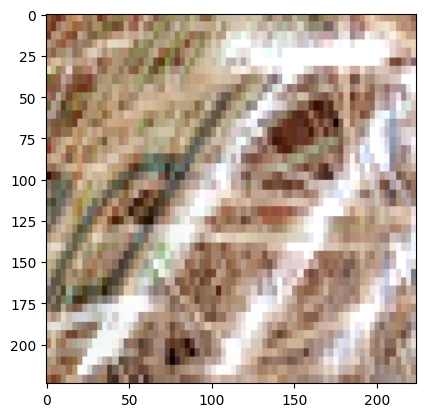

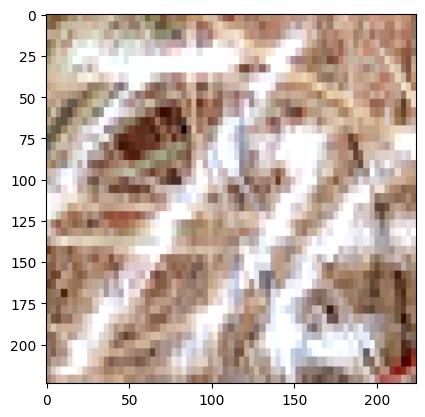

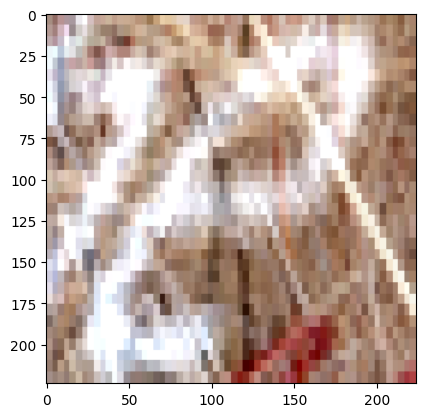

b'Titillium Web'
[[0.06487546 0.5242881  0.16879886 0.14286245 0.09917512]
 [0.06330258 0.5296393  0.1699759  0.13886379 0.09821845]
 [0.06322329 0.5203586  0.17847328 0.14128156 0.09666326]]
[1 1 1]


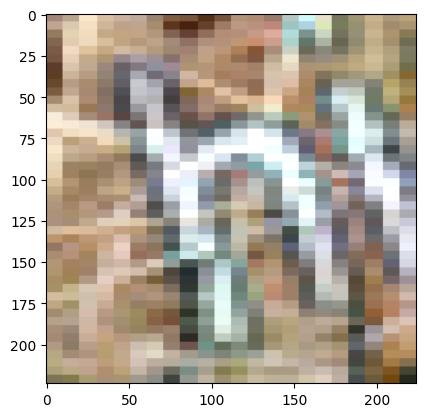

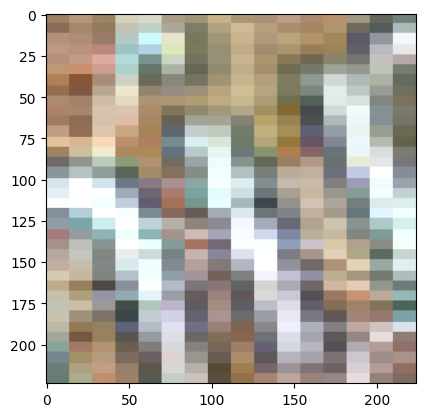

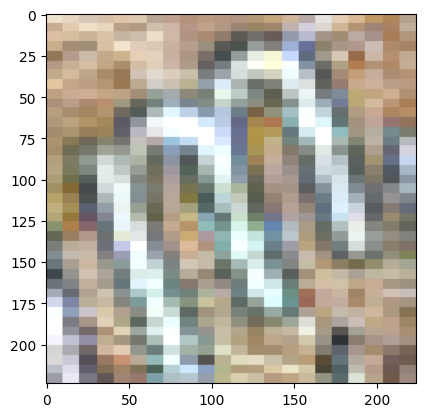

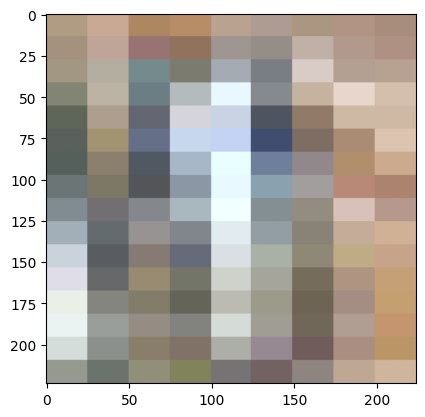

KeyboardInterrupt: 

In [133]:
results = get_predicted(SIZE)

In [ ]:
print(results)

In [ ]:
predict = model.predict(val_it, verbose=0)